# Project 9. Twitter COVID19 Network Analysis III


### 1. First we sort the data by date to focus on the timeframe from January to March 2020.

Use the timestamp attribute to restrict the collection to Twitter data in the period January
2020-March 2020.


In [1]:

print("divide into small files...")

n = 500_000

line_count = 0
file_count = 0
fout = open('TweetsCOV19_{0}.tsv'.format(file_count), 'w', encoding='utf-8')
with open('TweetsCOV19.tsv', 'r', encoding='utf-8') as file:
    for line in file:
        if line_count > 0 and line_count % n == 0:
            print("lines processed", line_count)
            fout.close()
            fout = open('TweetsCOV19_{0}.tsv'.format(file_count), 'w', encoding='utf-8')
            file_count = file_count + 1
            
        line_count = line_count + 1  
        fout.writelines(line)
        
fout.close()
print("finish")


divide into small files...
lines processed 500000
lines processed 1000000
lines processed 1500000
lines processed 2000000
lines processed 2500000
lines processed 3000000
lines processed 3500000
lines processed 4000000
lines processed 4500000
lines processed 5000000
lines processed 5500000
lines processed 6000000
lines processed 6500000
lines processed 7000000
lines processed 7500000
lines processed 8000000
finish


In [4]:
# filtration by date

import datetime
import pytz

# Define the UTC timezone
utc = pytz.UTC

print("start filtering!")

start_date = datetime.datetime(2020, 1, 1, tzinfo=utc)
end_date = datetime.datetime(2020, 3, 31, tzinfo=utc)

# todo: adjust to actual files count from cell0
max_file_index = 15

file_index = 0

fout = open('data_filtered.tsv', 'w', encoding='utf-8')
filtered_len = 0
for i in range(max_file_index):
    with open('TweetsCOV19_{0}.tsv'.format(i), 'r', encoding='utf-8') as file:
        for line in file:
            tweet_data = line.strip().split('\t')
            timestamp = datetime.datetime.strptime(tweet_data[2], "%a %b %d %H:%M:%S %z %Y").replace(tzinfo=pytz.utc)
            if start_date <= timestamp <= end_date:
                fout.writelines(line)
                filtered_len = filtered_len + 1 

fout.close()
print("source dataset was filtered, count", filtered_len)

start filtering!
source dataset was filtered, count 3779593


In [1]:
class MyTweet:
    def __init__(self, id: str, mentions: set, sentiment: int, data: list):
        self.id = id
        self.mentions = mentions
        self.data = data
        self.sentiment = sentiment

    def __hash__(self):
        return hash(self.id)
    
    def __eq__(self, other):
        if isinstance(other, MyTweet):
            return self.id == other.id
        return False
    
    def __str__(self):
        return self.id


filtered_data = []

import datetime
# import pytz

start_time = datetime.datetime.now()

print("start reading data...")
line_count = 0
with open('data_filtered.tsv', 'r', encoding='utf-8') as file:
    for line in file:
        tweet_data = line.strip().split('\t')
        if tweet_data[9] != 'null;': # ignore tweets without mentions
            # timestamp = datetime.datetime.strptime(tweet_data[2], "%a %b %d %H:%M:%S %z %Y").replace(tzinfo=pytz.utc)
            mentions = set([s.strip() for s in tweet_data[9].split() if s.strip()])
        
            if len(mentions) > 0:
                sentiment = sum([int(score) for score in tweet_data[8].split()])
                filtered_data.append(MyTweet(tweet_data[0], mentions, sentiment, tweet_data))     
                
            line_count += 1
            if line_count % 100_000 == 0:
                print("lines processed", line_count)

print("filtered {0} tweets with mentions in {1}".format(len(filtered_data), datetime.datetime.now() - start_time))

start reading data...
lines processed 100000
lines processed 200000
lines processed 300000
lines processed 400000
lines processed 500000
lines processed 600000
lines processed 700000
lines processed 800000
lines processed 900000
lines processed 1000000
lines processed 1100000
lines processed 1200000
lines processed 1300000
lines processed 1400000
filtered 1453447 tweets with mentions in 0:00:19.038856


### 2. Construct a Network

We want to construct a network according to the associated mention, where nodes
correspond to Twitter Ids, and an edge between two nodes is established if the
corresponding twitter ids share the same mention in their Mention string attributes. 

Write a script that implements this graph construction. What is the size of the graph in terms of
number of nodes and edges.

Save the adjacency matrix of this graph in file.

In [4]:
!pip install networkx

In [2]:
import networkx as nx
import datetime

start_time = datetime.datetime.now()

print('start composing graph from {} source'.format(len(filtered_data)))

# Construct the graph
G = nx.Graph()     
# G.add_nodes_from(filtered_data)

# helper dictionary for finding node by mention in graph 
mentions_to_nodes = {}

edges_to_add = set()

counter = 0
for tweet in filtered_data:
    counter += 1
    if counter % 10_000 == 0:
        print('processing {}th tweet, put batch to graph...'.format(counter))
        G.add_edges_from(edges_to_add)
        edges_to_add.clear()
        
    if counter == 100_000:
        print("break!")
        break
        
    for mention in tweet.mentions:
        if mention not in mentions_to_nodes:
            G.add_node(tweet)
            mentions_to_nodes[mention] = {tweet}
        else:
            # Add edges between nodes corresponding to Twitter IDs that share the same mention
            for node in mentions_to_nodes[mention]:
                edges_to_add.add((tweet, node))
                # G.add_edge(tweet, node)
            
            # Add the current tweet to the list of nodes for a mention.
            mentions_to_nodes[mention].add(tweet)


# Now outside the loop, add all edges at once
G.add_edges_from(edges_to_add)

print("Built a graph of {0} nodes and {1} edges in {2}".format(len(G.nodes), len(G.edges), datetime.datetime.now() - start_time))                
print("Number of unique mentions:", len(mentions_to_nodes))
print("Top 5 popular mentions:")
sorted_d = sorted(mentions_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)
for key, value in sorted_d[:5]:
    print("'{0}' - {1} tweets".format(key, len(value)))


start composing graph from 1453447 source
processing 10000th tweet, put batch to graph...
processing 20000th tweet, put batch to graph...
processing 30000th tweet, put batch to graph...
processing 40000th tweet, put batch to graph...
processing 50000th tweet, put batch to graph...
processing 60000th tweet, put batch to graph...
processing 70000th tweet, put batch to graph...
processing 80000th tweet, put batch to graph...
processing 90000th tweet, put batch to graph...
processing 100000th tweet, put batch to graph...
break!
Built a graph of 99999 nodes and 8281746 edges in 0:00:42.915142
Number of unique mentions: 134957
Top 5 popular mentions:
'realDonaldTrump' - 2834 tweets
'ColorsTV' - 1522 tweets
'jaketapper' - 1329 tweets
'BiggBoss' - 1051 tweets
'BTS_twt' - 648 tweets


In [3]:
# Save the adjacency matrix of the graph
nx.write_adjlist(G, "adjacency_matrix.txt")
print("Adjacency matrix saved")

Adjacency matrix saved


### 3. Components

Write a script that uses NetworkX to identify the largest component, second largest and
third largest component of the network as well as the average path length.

In [10]:
import networkx as nx

components = sorted(nx.connected_components(G), key=len, reverse=True)
print("Graph contains {} components".format(len(components)))

largest_component = None
second_largest_component = None
third_largest_component = None
avg_path_length = None

for i, component in enumerate(components):
    if i < 3:
        print("Size of the component", i + 1, ":", len(component))
    component_graph = G.subgraph(component)
    if i == 0:
        largest_component = component_graph
    elif i == 1:
        second_largest_component = component_graph
    elif i == 2:
        third_largest_component = component_graph
    else: # Exit loop if we have identified the top three components
        break

Graph contains 44581 components
Size of the component 1 : 45944
Size of the component 2 : 129
Size of the component 3 : 67


In [11]:
import networkx as nx
from itertools import islice

def bfs_sample(src_graph, size):  
    sorted_nodes = sorted(src_graph.nodes, key=lambda node: src_graph.degree(node), reverse=True)
    source = next(iter(sorted_nodes))
    
    if size > len(src_graph.nodes):
        size = len(src_graph.nodes)

    visited_nodes = [source]
    bfs_gen = nx.bfs_edges(src_graph, source)

    for edge in islice(bfs_gen, 0, size - 1):
        visited_nodes.append(edge[1])

    return src_graph.subgraph(visited_nodes)


print('Average shortest path length in the 1st largest component', nx.average_shortest_path_length(bfs_sample(largest_component, 1000)))
print('Average shortest path length in the 2nd largest component', nx.average_shortest_path_length(bfs_sample(second_largest_component, 1000)))
print('Average shortest path length in the 3rd largest component', nx.average_shortest_path_length(bfs_sample(third_largest_component, 1000)))


Average shortest path length in the 1st largest component 1.6816616616616618
Average shortest path length in the 2nd largest component 1.718265503875969
Average shortest path length in the 3rd largest component 1.0


### 4. Degree centrality distribution

Write a script that plots the degree centrality distribution and cumulative degree centrality distribution.

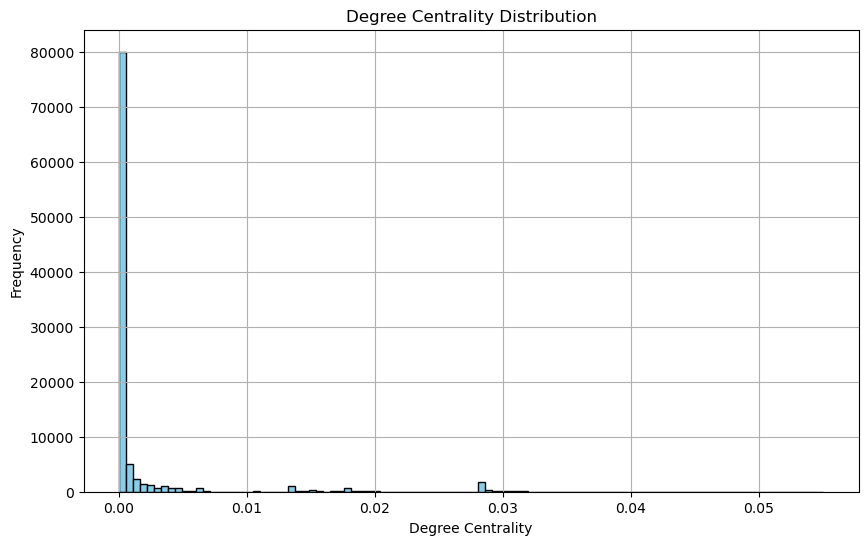

In [4]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

import matplotlib.pyplot as plt

# Plot degree centrality distribution
plt.figure(figsize=(10, 6))
plt.hist(list(degree_centrality.values()), bins=100, color='skyblue', edgecolor='black')
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

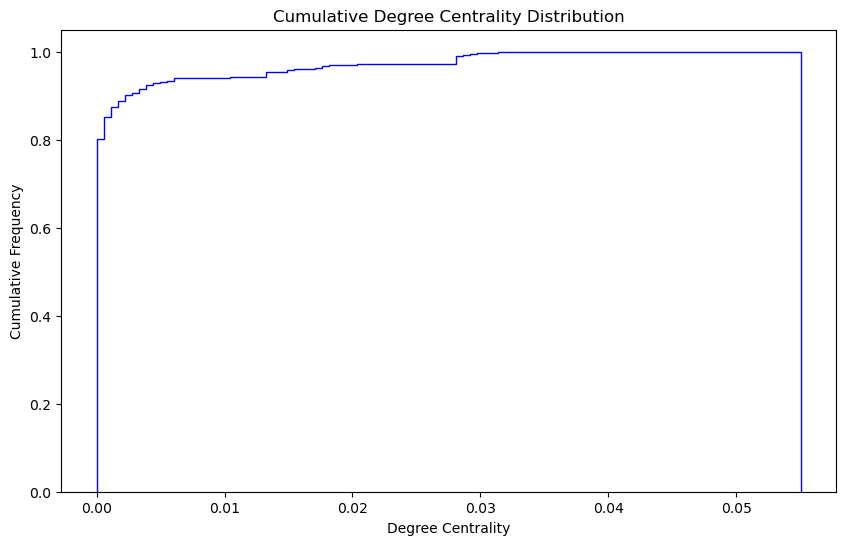

In [13]:
# Calculate cumulative degree centrality distribution
degree_centrality = nx.degree_centrality(G)

# Plot cumulative degree centrality distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(list(degree_centrality.values()), bins=100, density=True, cumulative=True, histtype='step', alpha=1, color='b')
plt.title('Cumulative Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Cumulative Frequency')
plt.show()


### 5. Power law

We want to test the extent to which the degree centrality distributions in 3) fit a power law
distribution. You may inspire from the implementation in powerlaw · PyPI of the power-law
distribution, or can use alternative one of your choice. It is important to quantify the
goodness of fit using p-value. Typically, when p-value is greater than 10%, we can state that
power-law is a plausible fit to the (distribution) data.

In [1]:
!pip install powerlaw
!pip install math

  Using cached powerlaw-1.5-py3-none-any.whl.metadata (9.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached powerlaw-1.5-py3-none-any.whl (24 kB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


In [8]:
import powerlaw
import math

# degree_centrality = nx.degree_centrality(G)
#data = [math.log10(abs(x)) for x in list(degree_centrality.values())]
# data = [math.log2(x) for x in list(degree_centrality.values()) if x != 0.0]

data = [value for value in degree_centrality.values() if value != 0]

fitted = powerlaw.Fit(data)
print("alpha", fitted.power_law.alpha)
print("xmin", fitted.power_law.xmin)

dist = ['power_law', 'exponential', 'lognormal', 'truncated_power_law']
for d1 in dist:
    for d2 in dist:
        if d1 != d2:
            R, p = fitted.distribution_compare('truncated_power_law', 'exponential')
            print("{0} {1}: p {2} R {3}".format(d1, d2, p, R))
            if p > 0.1:
                print("!!! good fit {0} {1}: p {2} R {3}".format(d1, d2, p, R))
                
print("finish")          

Calculating best minimal value for power law fit


alpha 14.567651190372358
xmin 0.028850577011540233
power_law exponential: p 6.259553947915207e-17 R 26.6828391963481
power_law lognormal: p 6.259553947915207e-17 R 26.6828391963481
power_law truncated_power_law: p 6.259553947915207e-17 R 26.6828391963481
exponential power_law: p 6.259553947915207e-17 R 26.6828391963481
exponential lognormal: p 6.259553947915207e-17 R 26.6828391963481
exponential truncated_power_law: p 6.259553947915207e-17 R 26.6828391963481
lognormal power_law: p 6.259553947915207e-17 R 26.6828391963481
lognormal exponential: p 6.259553947915207e-17 R 26.6828391963481
lognormal truncated_power_law: p 6.259553947915207e-17 R 26.6828391963481
truncated_power_law power_law: p 6.259553947915207e-17 R 26.6828391963481
truncated_power_law exponential: p 6.259553947915207e-17 R 26.6828391963481
truncated_power_law lognormal: p 6.259553947915207e-17 R 26.6828391963481
finish


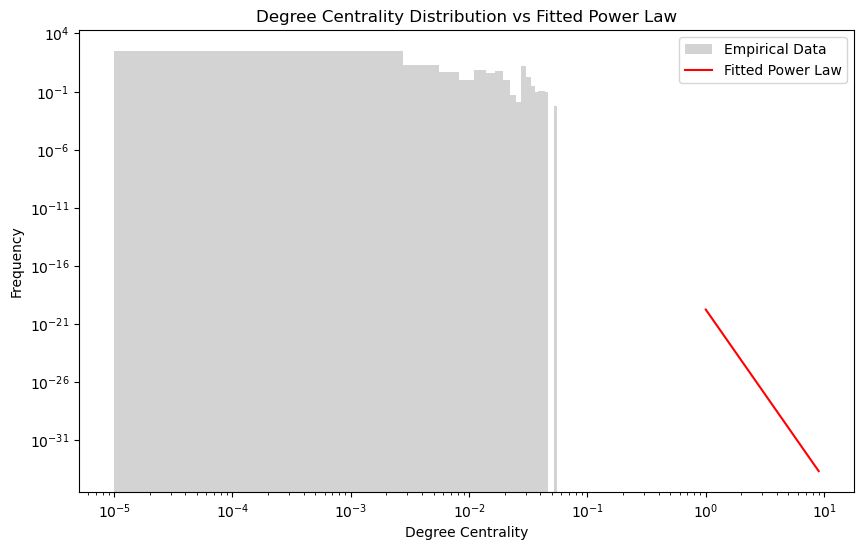

In [9]:
import matplotlib.pyplot as plt

# Visualize the distribution with fitted powerlaw
plt.figure(figsize=(10, 6))
plt.hist(data, bins=20, density=True, color='lightgrey', label='Empirical Data')
plt.plot(range(1, 10), [fitted.power_law.pdf(x) for x in range(1, 10)], color='r', label='Fitted Power Law')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Centrality Distribution vs Fitted Power Law')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.show()

### 6-7. Sentiments
We want to capitalize on the information about the sentiment of tweet. Write a script that
calculates the overall sentiment of each tweet by adding the positive and negative sentiment
score available in the sentiment attribute.

In [17]:
overall_sentiments = {}
for tweet in G.nodes:
    overall_sentiments[tweet] = tweet.sentiment

Now we want to evaluate the extent to which positive (resp. negative) sentiment tweet
connects with positive (resp. negative) sentiment tweet. Suggest a script that traverses all
edges and calculates the proportion of positive-positive connection, negative-negative
connection and positive-negative or negative-positive connection.

In [19]:
positive_positive_connections = 0
negative_negative_connections = 0
positive_negative_connections = 0

for edge in G.edges:
    from_sentiment = overall_sentiments[edge[0]]
    to_sentiment = overall_sentiments[edge[1]]
    if from_sentiment > 0 and to_sentiment > 0:
        positive_positive_connections += 1
    elif from_sentiment < 0 and to_sentiment < 0:
        negative_negative_connections += 1
    else:
        positive_negative_connections += 1
        
total_edges = len(G.edges)
print("Proportion of positive-positive connections:", positive_positive_connections / total_edges)
print("Proportion of negative-negative connections:", negative_negative_connections / total_edges)
print("Proportion of positive-negative or negative-positive connections:", positive_negative_connections / total_edges)

Proportion of positive-positive connections: 0.0890044200824319
Proportion of negative-negative connections: 0.1134291005785495
Proportion of positive-negative or negative-positive connections: 0.7975664793390186


### 8. Time evolution (positive)
Now we want to take into account the time evolution. For this purpose, use the timestamp
of the tweets. 

Suggest a script that creates some time subdivision (by assigning a fixed
number of subdivisions between the largest and smallest recorded time of the tweets) and
calculates the evolution of the total number of positive sentiment tweets after each time
increment (subdivision). 

Suggest a parametric distribution (i.e., polynomial or exponential)
that best fits the obtained graph (using curve fitting method of your choice).

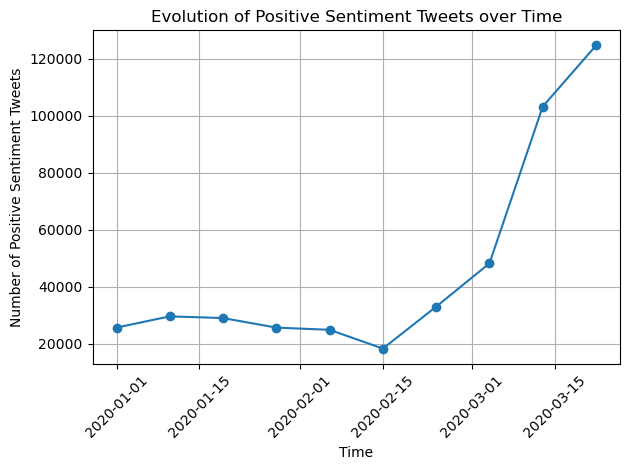

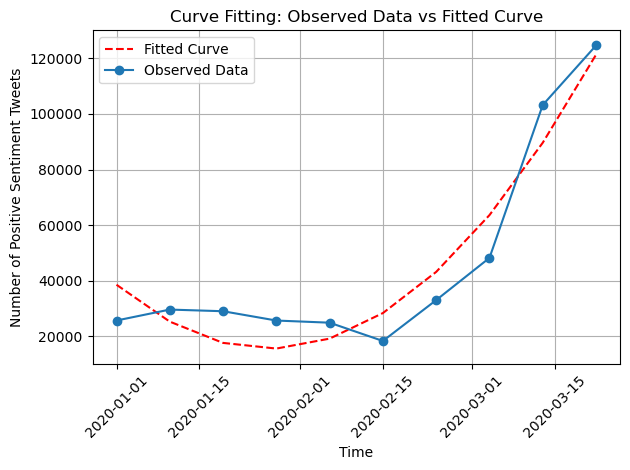

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract timestamps and sentiment scores from filtered data
timestamps = [tweet.data[2] for tweet in filtered_data]
sentiments = [tweet.data[8] for tweet in filtered_data]

# Convert timestamps to datetime objects for easier manipulation
timestamps = [datetime.datetime.strptime(ts, "%a %b %d %H:%M:%S %z %Y") for ts in timestamps]

# Determine the time range covered by the tweets
start_time = min(timestamps)
end_time = max(timestamps)
time_range = end_time - start_time

# Define the number of time intervals (subdivisions)
num_intervals = 10  # You can adjust this value as needed

# Calculate the duration of each time interval
interval_duration = time_range / num_intervals

# Initialize lists to store the number of positive sentiment tweets in each interval
interval_timestamps = [start_time + i * interval_duration for i in range(num_intervals)]
positive_sentiments_by_interval = []

# Iterate over each interval
for i in range(num_intervals):
    interval_start = start_time + i * interval_duration
    interval_end = interval_start + interval_duration

    # Count the number of positive sentiment tweets within the current interval
    num_positive_sentiments = sum(1 for ts, sentiment in zip(timestamps, sentiments) if interval_start <= ts <= interval_end and sum(map(int, sentiment.split())) > 0)
    positive_sentiments_by_interval.append(num_positive_sentiments)

# Plot the evolution of the total number of positive sentiment tweets over time
plt.plot(interval_timestamps, positive_sentiments_by_interval, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Number of Positive Sentiment Tweets')
plt.title('Evolution of Positive Sentiment Tweets over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# fitting a polynomial function
def polynomial_func(x, a, b, c):
    return a * np.array(x)**2 + b * np.array(x) + c  # Convert range to array

# Perform curve fitting
popt, pcov = curve_fit(polynomial_func, range(num_intervals), positive_sentiments_by_interval)

# Plot the fitted curve
plt.plot(interval_timestamps, polynomial_func(range(num_intervals), *popt), 'r--', label='Fitted Curve')
plt.plot(interval_timestamps, positive_sentiments_by_interval, marker='o', linestyle='-', label='Observed Data')
plt.xlabel('Time')
plt.ylabel('Number of Positive Sentiment Tweets')
plt.title('Curve Fitting: Observed Data vs Fitted Curve')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 9. Time evolution (negative)
Repeat 8) when using negative sentiment tweets.

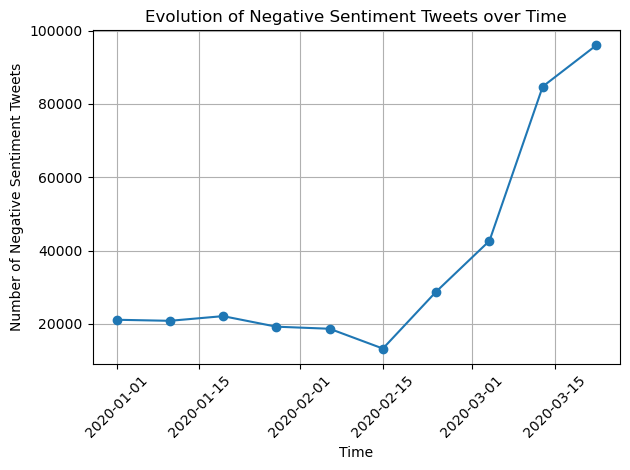

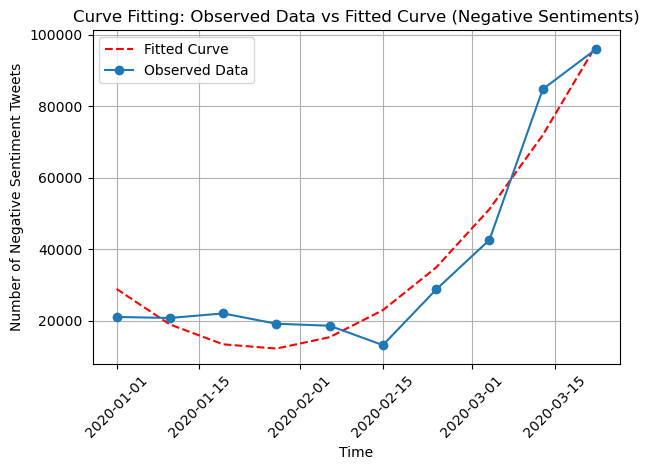

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Initialize lists to store the number of negative sentiment tweets in each interval
negative_sentiments_by_interval = []

# Iterate over each interval
for i in range(num_intervals):
    interval_start = start_time + i * interval_duration
    interval_end = interval_start + interval_duration

    # Count the number of negative sentiment tweets within the current interval
    num_negative_sentiments = sum(1 for ts, sentiment in zip(timestamps, sentiments) if interval_start <= ts <= interval_end and sum(map(int, sentiment.split())) < 0)
    negative_sentiments_by_interval.append(num_negative_sentiments)

# Plot the evolution of the total number of negative sentiment tweets over time
plt.plot(interval_timestamps, negative_sentiments_by_interval, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Number of Negative Sentiment Tweets')
plt.title('Evolution of Negative Sentiment Tweets over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform curve fitting for negative sentiments
popt_negative, pcov_negative = curve_fit(polynomial_func, range(num_intervals), negative_sentiments_by_interval)

# Plot the fitted curve for negative sentiments
plt.plot(interval_timestamps, polynomial_func(range(num_intervals), *popt_negative), 'r--', label='Fitted Curve')
plt.plot(interval_timestamps, negative_sentiments_by_interval, marker='o', linestyle='-', label='Observed Data')
plt.xlabel('Time')
plt.ylabel('Number of Negative Sentiment Tweets')
plt.title('Curve Fitting: Observed Data vs Fitted Curve (Negative Sentiments)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
!pip install ndlib

   ---------------------------------------- 0.0/110.2 kB ? eta -:--:--
   ---------------------------------------- 110.2/110.2 kB 3.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.3 MB 9.3 MB/s eta 0:00:01
   ---- ----------------------------------- 1.0/8.3 MB 10.2 MB/s eta 0:00:01
   ------ --------------------------------- 1.4/8.3 MB 11.0 MB/s eta 0:00:01
   ------ --------------------------------- 1.4/8.3 MB 11.0 MB/s eta 0:00:01
   ---------- ----------------------------- 2.2/8.3 MB 8.8 MB/s eta 0:00:01
   ------------- -------------------------- 2.8/8.3 MB 9.3 MB/s eta 0:00:01
   ---------------- ----------------------- 3.4/8.3 MB 9.9 MB/s eta 0:00:01
   ----------------- ---------------------- 3.6/8.3 MB 9.3 MB/s eta 0:00:01
   ----------------------- ---------------- 4.8/8.3 MB 11.0 MB/s eta 0:00:01
   -------------------------- ------------- 5.5/8.3 MB 11.3 MB/s eta 0:00:01
   ------------

### 10.  Negative Sentiment Propagation

We want to assimilate negative sentiment propgation to a virus propagation case. 

Use the NDLIB library to simulate an SIS propagation model where the overall time is given by the
number of subdivisions in 8), and the graph is set by the graph configuration at time
increment 1 (after first subdivision).

Select several choices for parameters lambda and beta to generate contamination (total number of negative sentiments) close to that observed in 9) (although no guarantee that this can be achieved). 

Draw the simulation showing the number of contamination (number of tweets with negative sentiment) over time, and compare this with that obtained in 8).

In [12]:
import networkx as nx
import datetime
import pytz

start_date = datetime.datetime(2020, 1, 1, tzinfo=pytz.UTC)

# Define the number of time intervals (subdivisions)
num_intervals = 10  # You can adjust this value as needed

# Calculate the duration of each time interval
interval_duration = time_range / num_intervals

# Initialize lists to store the number of positive sentiment tweets in each interval
interval_timestamps = [start_date + i * interval_duration for i in range(num_intervals)]

interval_start = (start_date + interval_duration).replace(tzinfo=pytz.UTC)
interval_end = (interval_start + interval_duration).replace(tzinfo=pytz.UTC)
print("select tweets from {0} to {1}".format(interval_start, interval_end)) 

select tweets from 2020-01-09 23:59:59.200000+00:00 to 2020-01-18 23:59:58.400000+00:00


In [13]:
time_range_1 = interval_end - interval_start
interval_duration_1 = time_range_1 / num_intervals
print(interval_duration_1)

interval_1_timestamps = []
# interval_1_timestamps.append(interval_start)

negative_sentiments_interval1 = []
for i in range(num_intervals):
    interval_start1 = interval_start + i * interval_duration_1
    interval_end1 = interval_start + (i + 1) * interval_duration_1
    
    interval_1_timestamps.append(interval_end1)

    # Count the number of negative sentiment tweets within the current interval
    num_negative_sentiments = sum(1 for ts, sentiment in zip(timestamps, sentiments) 
                                  if interval_start1 <= ts <= interval_end1 and sum(map(int, sentiment.split())) < 0)
    negative_sentiments_interval1.append(num_negative_sentiments)
    
print("got neg sent for time interval 1")

21:35:59.920000
got neg sent for time interval 1


In [14]:
# Set up the network using the graph configuration at time increment 1, add nodes and edges to nx.graph() G1
data_attime1 = []   
for tweet in filtered_data:
    timestamp = datetime.datetime.strptime(tweet.data[2], "%a %b %d %H:%M:%S %z %Y").replace(tzinfo=pytz.UTC)
    if interval_start <= timestamp <= interval_end:
        data_attime1.append(tweet)

print("selected {0} tweets in interval {1} - {2}".format(len(data_attime1), interval_start, interval_end))
G1 = nx.Graph()     

# helper dictionary for finding node by mention in graph 
mentions_to_nodes = {}

edges_to_add = set()

counter = 0
for tweet in data_attime1:
    counter += 1
    if counter % 10_000 == 0:
        print('processing {}th tweet, put batch to graph...'.format(counter))
        G1.add_edges_from(edges_to_add)
        edges_to_add.clear()
             
    for mention in tweet.mentions:
        if mention not in mentions_to_nodes:
            G1.add_node(tweet)
            mentions_to_nodes[mention] = {tweet}
        else:
            # Add edges between nodes corresponding to Twitter IDs that share the same mention
            for node in mentions_to_nodes[mention]:
                edges_to_add.add((tweet, node))
                # G.add_edge(tweet, node)
            
            # Add the current tweet to the list of nodes for a mention.
            mentions_to_nodes[mention].add(tweet)


# Now outside the loop, add all edges at once
G1.add_edges_from(edges_to_add)

print("Built a graph of {0} nodes and {1} edges in {2}".format(len(G1.nodes), len(G1.edges), datetime.datetime.now().replace(tzinfo=pytz.UTC) - start_time.replace(tzinfo=pytz.UTC)))                
print("Number of unique mentions:", len(mentions_to_nodes))
print("Top 5 popular mentions:")
sorted_d = sorted(mentions_to_nodes.items(), key=lambda x: len(x[1]), reverse=True)
for key, value in sorted_d[:5]:
    print("'{0}' - {1} tweets".format(key, len(value)))

selected 86907 tweets in interval 2020-01-09 23:59:59.200000+00:00 - 2020-01-18 23:59:58.400000+00:00
processing 10000th tweet, put batch to graph...
processing 20000th tweet, put batch to graph...
processing 30000th tweet, put batch to graph...
processing 40000th tweet, put batch to graph...
processing 50000th tweet, put batch to graph...
processing 60000th tweet, put batch to graph...
processing 70000th tweet, put batch to graph...
processing 80000th tweet, put batch to graph...
Built a graph of 86907 nodes and 10131732 edges in 1595 days, 19:27:21.311523
Number of unique mentions: 114984
Top 5 popular mentions:
'ColorsTV' - 2824 tweets
'realDonaldTrump' - 2423 tweets
'BiggBoss' - 1802 tweets
'EndemolShineIND' - 1186 tweets
'jaketapper' - 1115 tweets


In [15]:
# nodes from subdivision 0 with negative sentiment
initial_infected_nodes = []

interval_end = (start_date + interval_duration).replace(tzinfo=pytz.UTC)

for tweet in filtered_data:
    timestamp = datetime.datetime.strptime(tweet.data[2], "%a %b %d %H:%M:%S %z %Y").replace(tzinfo=pytz.UTC)
    if tweet.sentiment < 0 and start_date <= timestamp <= interval_end:
        initial_infected_nodes.append(tweet)

print("selected {0} initial infected nodes in time interval {1} - {2}".format(len(initial_infected_nodes), start_date, interval_end))

selected 21113 infected nodes in time interval 2020-01-01 00:00:00+00:00 - 2020-01-09 23:59:59.200000+00:00


configured with beta=0.6 lambda=0.8, computing contamination_over_time...


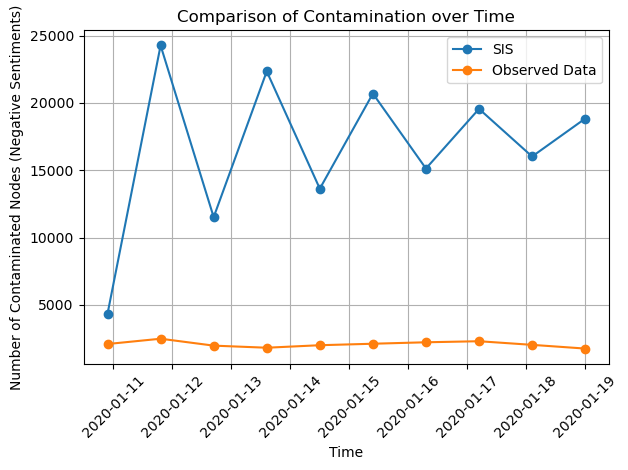

In [27]:
import ndlib.models.epidemics.SISModel as sis
from ndlib.models.ModelConfig import Configuration

# Define the parameters for the SIS model

# Initialize a configuration object
config = Configuration()

# Set model parameters
beta = 0.6
lmbda = 0.8
config.add_model_parameter('beta', beta)  # Infection rate
config.add_model_parameter('lambda', lmbda)  # Recovery rate

# Specify initial node states
for node in initial_infected_nodes:
    config.add_node_configuration("state", node, 1)  # 1 represents infected state, 0 represents susceptible state

# Specify initial node states
for node in G1.nodes:
    config.add_node_configuration("state", node, 0)  # Set all nodes to susceptible initially

# Create an instance of the SIS model with the configuration
model = sis(G1)
model.set_initial_status(config)
print("configured with beta={0} lambda={1}, computing contamination_over_time...".format(beta, lmbda))

# Initialize lists to store the number of contaminated nodes over time for each parameter combination
contamination_over_time = []

# Run the simulation
iterations = model.iteration_bunch(num_intervals)

# Iterate over the iterations to extract the number of contaminated nodes at each time step
for iteration in iterations:
    # Extract the number of contaminated nodes at each time step
    contaminated_nodes_count = sum(1 for status in iteration['status'].values() if status == 1)

    # Store the number of contaminated nodes over time
    contamination_over_time.append(contaminated_nodes_count)
    

import matplotlib.pyplot as plt

# Plot the observed negative sentiment propagation from Task 8 for comparison
plt.plot(interval_1_timestamps, contamination_over_time, marker='o', linestyle='-', label='SIS')
plt.plot(interval_1_timestamps, negative_sentiments_interval1, marker='o', linestyle='-', label='Observed Data')

# Set plot labels and title
plt.xlabel('Time')
plt.ylabel('Number of Contaminated Nodes (Negative Sentiments)')
plt.title('Comparison of Contamination over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()